Going to rewrite the code to make sure I get it

In [4]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi

import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize

import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython


In [42]:
#define some s pre/post operators

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13



In [43]:
#sigmay = Matrix([[0,-I],[I,0]])

In [44]:
delta2,delta3=sym.symbols('delta_2 delta_3', real=True)
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False)
omegao, omegam=sym.symbols('Omega_o Omega_mu', real=True, negative=False)
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33')

a= sym.symbols('a')
ar,ai=sym.symbols('a_r a_i', real=True)
g=sym.symbols('g',real=True, negative=False)


In [45]:
H=omegam*s21+omegao*s32+ g*a*s31
H=H+Dagger(H)
H=H+delta2*s22+delta3*s33

H_no_a=H[:,:]
H_no_a[0,2]=0
H_no_a[2,0]=0
H_no_a

H_o=H_no_a[:,:]
H_o[0,1]=0
H_o[1,0]=0

H_mu=H_no_a[:,:]
H_mu[2,1]=0
H_mu[1,2]=0


H, H_no_a, H_o, H_mu

⎛⎡            _⎤                                             ⎞
⎜⎢ 0   Ωₘᵤ  g⋅a⎥  ⎡ 0   Ωₘᵤ  0 ⎤  ⎡0  0   0 ⎤  ⎡ 0   Ωₘᵤ  0 ⎤⎟
⎜⎢             ⎥  ⎢            ⎥  ⎢         ⎥  ⎢            ⎥⎟
⎜⎢Ωₘᵤ  δ₂   Ωₒ ⎥, ⎢Ωₘᵤ  δ₂   Ωₒ⎥, ⎢0  δ₂  Ωₒ⎥, ⎢Ωₘᵤ  δ₂   0 ⎥⎟
⎜⎢             ⎥  ⎢            ⎥  ⎢         ⎥  ⎢            ⎥⎟
⎝⎣a⋅g  Ωₒ   δ₃ ⎦  ⎣ 0   Ωₒ   δ₃⎦  ⎣0  Ωₒ  δ₃⎦  ⎣ 0    0   δ₃⎦⎠

In [46]:
LH=-I*spre(H)+I*spost(H)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L = LH + L21 + L12 + L32 + L31 + L22 + L33

L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)



In [47]:
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]
rhoflat

In [48]:
#change of variables to make things real to make it a bit faster maybe
CtoR = Matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])
CtoR=CtoR/2
CtoR_mat = np.matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])/2
t = CtoR*Matrix(rhoflat)
t

⎡      ρ₁₁      ⎤
⎢               ⎥
⎢      ρ₂₂      ⎥
⎢               ⎥
⎢      ρ₃₃      ⎥
⎢               ⎥
⎢   ρ₁₂   ρ₂₁   ⎥
⎢   ─── + ───   ⎥
⎢    2     2    ⎥
⎢               ⎥
⎢  ⅈ⋅ρ₁₂   ⅈ⋅ρ₂₁⎥
⎢- ───── + ─────⎥
⎢    2       2  ⎥
⎢               ⎥
⎢   ρ₁₃   ρ₃₁   ⎥
⎢   ─── + ───   ⎥
⎢    2     2    ⎥
⎢               ⎥
⎢  ⅈ⋅ρ₁₃   ⅈ⋅ρ₃₁⎥
⎢- ───── + ─────⎥
⎢    2       2  ⎥
⎢               ⎥
⎢   ρ₂₃   ρ₃₂   ⎥
⎢   ─── + ───   ⎥
⎢    2     2    ⎥
⎢               ⎥
⎢  ⅈ⋅ρ₂₃   ⅈ⋅ρ₃₂⎥
⎢- ───── + ─────⎥
⎣    2       2  ⎦

In [49]:
rhoflat

In [50]:
Lreal = sym.simplify(CtoR*L*CtoR.inv())
Lreal = Lreal.subs(a,ar+I*ai)
Lreal


Lfunc = sym.lambdify((a,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),L)

Lrealfunc = sym.lambdify((ar,ai,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),Lreal)

In [53]:
L

⎡   1                       0                                     0           
⎢                                                                             
⎢                 γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                              
⎢-ⅈ⋅Ωₘᵤ   -ⅈ⋅δ₂ - ──── - ─────── - ─────────────                -ⅈ⋅Ωₒ         
⎢                  2        2            2                                    
⎢                                                                             
⎢                                                         γ₁₃   γ₂₃   γ_3d   γ
⎢-ⅈ⋅a⋅g                   -ⅈ⋅Ωₒ                   -ⅈ⋅δ₃ - ─── - ─── - ──── - ─
⎢                                                          2     2     2      
⎢                                                                             
⎢                                                                             
⎢ ⅈ⋅Ωₘᵤ                     0                                     0           
⎢                                                   

In [62]:
Ho_eigs=list(H_o.eigenvals().keys())
Hmu_eigs=list(H_mu.eigenvals().keys())


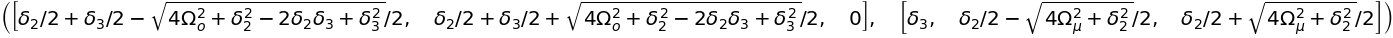

In [63]:
Ho_eigs,Hmu_eigs

In [72]:
Ho_del2=sym.solve(Ho_eigs[1],delta2)
Ho_del2

In [71]:
Hmu_del2=sym.solve(Hmu_eigs[0]**2-Hmu_eigs[1]**2,delta2)[0]
Hmu_del2

In [76]:
#L_o=L.subs([(omegam,0),(delta2,Ho_del2)])
#L_mu=L.subs([(omegao,0),(delta2,Hmu_del2)])
L_o=sym.simplify(L.subs([(omegam,0),(delta2,omegao**2/delta3)]))
L_mu=sym.simplify(L.subs([(omegao,0),(delta2,-omegam**2/delta3+delta3)]))

In [77]:
L_o

⎡   1                   0                                 0                   
⎢                                                                             
⎢               2                                                             
⎢           ⅈ⋅Ωₒ    γ_2d             γₘᵤ                                      
⎢   0     - ───── - ──── - γₘᵤ⋅n_b - ───                -ⅈ⋅Ωₒ                 
⎢             δ₃     2                2                                       
⎢                                                                             
⎢                                                 γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b  
⎢-ⅈ⋅a⋅g               -ⅈ⋅Ωₒ               -ⅈ⋅δ₃ - ─── - ─── - ──── - ───────  
⎢                                                  2     2     2        2     
⎢                                                                             
⎢                                                                             
⎢                                                   

In [78]:
L_mu

⎡   1                      0                                    0             
⎢                                                                             
⎢              2                                                              
⎢         ⅈ⋅Ωₘᵤ           γ_2d             γₘᵤ                                
⎢-ⅈ⋅Ωₘᵤ   ────── - ⅈ⋅δ₃ - ──── - γₘᵤ⋅n_b - ───                  0             
⎢           δ₃             2                2                                 
⎢                                                                             
⎢                                                       γ₁₃   γ₂₃   γ_3d   γₘᵤ
⎢-ⅈ⋅a⋅g                    0                    -ⅈ⋅δ₃ - ─── - ─── - ──── - ───
⎢                                                        2     2     2        
⎢                                                                             
⎢                                                                             
⎢                                                   

In [93]:
L_o_null=Matrix(L_o[:,:])
L_o_null[0,:]=sym.zeros(1,9)

In [94]:
L_o_null

⎡   0                   0                                 0                   
⎢                                                                             
⎢               2                                                             
⎢           ⅈ⋅Ωₒ    γ_2d             γₘᵤ                                      
⎢   0     - ───── - ──── - γₘᵤ⋅n_b - ───                -ⅈ⋅Ωₒ                 
⎢             δ₃     2                2                                       
⎢                                                                             
⎢                                                 γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b  
⎢-ⅈ⋅a⋅g               -ⅈ⋅Ωₒ               -ⅈ⋅δ₃ - ─── - ─── - ──── - ───────  
⎢                                                  2     2     2        2     
⎢                                                                             
⎢                                                                             
⎢                                                   

In [95]:
L_mu_null=Matrix(L_mu[:,:])
L_mu_null[0,:]=sym.zeros(1,9)

In [97]:
L_mu_null.nullspace()

KeyboardInterrupt: 

In [139]:
def rho_on_resonance(L, delta3vals):
    Lfunc = sym.lambdify((a, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),L)
    
    rho=np.zeros((9,len(delta3vals)),dtype=np.complex_)
    
    for ii, del3val in enumerate(delta3vals):
        if del3val != 0:
            Lmatrix=Lfunc(aval,del3val, gamma13val, gamma23val, gamma2dval, gamma3dval, nbathval,gammamuval,omegaoval,omegamval,gval)
            rho[:,ii] = np.reshape(np.linalg.solve(Lmatrix.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T),9)
        else:
            rho[:,ii]=np.nan
    return rho


In [193]:
aval=0
gamma13val=1./22e-3
gamma23val=1./22e-3
gamma2dval=1./1e-6
gamma3dval=1./1e-6
nbathval=20
gammamuval=1./((nbathval+1)*11e-3)
gval=0
omegaoval=1e7
omegamval=1e7
ndelta2=501
ndelta3=501

delta2vals=np.linspace(-40e6,40e6,ndelta2)
delta3vals=np.linspace(-40e6,40e6,ndelta3)

In [194]:
rho_o=rho_on_resonance(L_o, delta3vals)

In [195]:
rho_mu=rho_on_resonance(L_mu, delta3vals)

In [196]:
Matrix(rho_mu[:,1])

⎡0.500015062850995 + 5.50861239833398e-20⋅ⅈ ⎤
⎢                                           ⎥
⎢8.06866564771965e-6 - 1.08091433573393e-7⋅ⅈ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢8.06866564771965e-6 + 1.08091433573452e-7⋅ⅈ⎥
⎢                                           ⎥
⎢ 0.499984937149005 - 5.5052787191078e-20⋅ⅈ ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎣                     0                     ⎦

In [197]:
Matrix(rho_o[:,1])

⎡0.440585466946113 + 5.90361004335898e-16⋅ⅈ ⎤
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢0.279795880176805 - 1.26308590435301e-16⋅ⅈ ⎥
⎢                                           ⎥
⎢4.74418374794868e-5 - 1.27099387671394e-6⋅ⅈ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢4.74418374794868e-5 + 1.27099387671407e-6⋅ⅈ⎥
⎢                                           ⎥
⎣0.279618652877082 - 1.26559117048823e-16⋅ⅈ ⎦

In [198]:
rhoflat

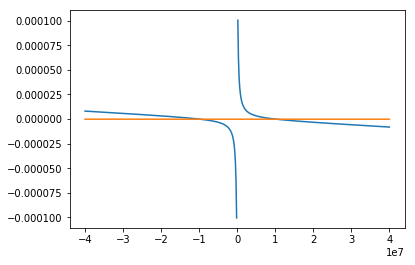

In [199]:
plt.plot(delta3vals,np.real(rho_mu[1,:]))
plt.plot(delta3vals,np.imag(rho_mu[1,:]))

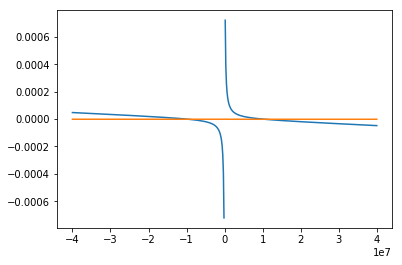

In [200]:
plt.plot(delta3vals,np.real(rho_o[5,:]))
plt.plot(delta3vals,np.imag(rho_o[5,:]))